# imports

In [1]:
import pandas as pd
import numpy as np
import sklearn
import pickle 
import time 
import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
%run function_proposed_gcn.py

In [3]:
with open('fraudTrain.pkl', 'rb') as file:
    fraudTrain = pickle.load(file)    

In [4]:
df = fraudTrain[::10]

df = df.reset_index()

df.is_fraud.mean()

# df_train, df_test = sklearn.model_selection.train_test_split(df)

0.005807854431707643

In [8]:
df_results = try_2(df, 0.005807, 0.005836, 10e+04, 0.3)

In [9]:
df_results

,model,time,acc,pre,rec,f1,auc,graph_based,method,throw_rate,train_size,train_cols,train_frate,test_size,test_frate,hyper_params,theta,gamma
0,GCN,None,0.993898,0.0,0.0,0.0,0.822009,True,Proposed,0.005807,7864,amt,0.003942,2622,0.005836,None,100000.0,0.3


In [10]:
df_results = try_2(df, 0.005807, 0.005836, 10e+03, 0.3)

In [11]:
df_results

,model,time,acc,pre,rec,f1,auc,graph_based,method,throw_rate,train_size,train_cols,train_frate,test_size,test_frate,hyper_params,theta,gamma
0,GCN,None,0.994661,0.0,0.0,0.0,0.833356,True,Proposed,0.005807,7864,amt,0.004196,2622,0.005836,None,10000.0,0.3


In [13]:
df.is_fraud.mean()

0.005807854431707643

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx
import sklearn
import xgboost as xgb

# sklearn
from sklearn import model_selection # split함수이용
from sklearn import ensemble # RF,GBM
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# gnn
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv


In [6]:
def down_sample_textbook(df):
    df_majority = df[df.is_fraud==0].copy()
    df_minority = df[df.is_fraud==1].copy()
    df_maj_dowsampled = sklearn.utils.resample(df_majority, n_samples=len(df_minority), replace=False, random_state=42)
    df_downsampled = pd.concat([df_minority, df_maj_dowsampled])
    return df_downsampled

def compute_time_difference(group):
    n = len(group)
    result = []
    for i in range(n):
        for j in range(n):
            time_difference = abs(group.iloc[i].trans_date_trans_time.value - group.iloc[j].trans_date_trans_time.value)
            result.append([group.iloc[i].name, group.iloc[j].name, time_difference])
    return result

def mask(df):
    df_tr,df_test = sklearn.model_selection.train_test_split(df, random_state=42)
    N = len(df)
    train_mask = [i in df_tr.index for i in range(N)]
    test_mask = [i in df_test.index for i in range(N)]
    train_mask = np.array(train_mask)
    test_mask = np.array(test_mask)
    return train_mask, test_mask

def edge_index_selected(edge_index):
    theta = edge_index[:,2].mean()
    edge_index[:,2] = (np.exp(-edge_index[:,2]/theta) != 1)*(np.exp(-edge_index[:,2]/theta))
    edge_index = edge_index.tolist()
    mean_ = np.array(edge_index)[:,2].mean()
    selected_edges = [(int(row[0]), int(row[1])) for row in edge_index if row[2] > mean_]
    edge_index_selected = torch.tensor(selected_edges, dtype=torch.long).t()
    return edge_index_selected



In [7]:
df.shape

(104858, 23)

In [8]:
train_mask, test_mask = mask(df)
df_tr,df_test = sklearn.model_selection.train_test_split(df, random_state=42)

In [9]:
df

,index,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:00,2.703190e+15,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,10,2019-01-01 00:06:00,4.642890e+12,fraud_Rutherford-Mertz,grocery_pos,24.74,Eddie,Mendez,M,1831 Faith View Suite 653,...,40.7491,-95.0380,7297,IT trainer,1990-07-13,d71c95ab6b7356dd74389d41df429c87,1325376383,40.275891,-96.011548,0
2,20,2019-01-01 00:13:00,4.469780e+18,fraud_Bauch-Raynor,grocery_pos,57.34,Gregory,Graham,M,4005 Dana Glens,...,42.7280,-71.1810,47249,Market researcher,1980-11-22,139a1bee15be607d79fe173bfcb2502a,1325376788,42.268760,-71.217297,0
3,30,2019-01-01 00:22:00,1.800950e+14,"fraud_Kihn, Abernathy and Douglas",shopping_net,3.66,Tammie,Harper,F,57887 Gutierrez Harbor,...,43.7575,-122.4810,597,Forensic psychologist,1961-05-19,870c92b288a974a2faf1f24b05c27e33,1325377356,44.278191,-121.815161,0
4,40,2019-01-01 00:30:00,6.763730e+11,"fraud_Christiansen, Goyette and Schamberger",gas_transport,53.60,Vicki,Mendoza,F,3645 Atkins Island Apt. 238,...,39.7562,-98.4462,242,Tourism officer,1987-07-18,f1566e9623814dd277dfa2a9bf83ea36,1325377849,40.332519,-99.062962,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104853,1048530,2020-03-10 15:53:00,4.746000e+12,fraud_Langworth LLC,personal_care,6.18,Carrie,Washington,F,6114 Adams Harbor Suite 096,...,41.4802,-86.6919,1423,"Psychologist, forensic",1998-10-07,a8119f2c9856637af2a6d3a92ae41892,1362930809,41.945985,-86.088059,0
104854,1048540,2020-03-10 15:58:00,6.304520e+11,fraud_Prosacco LLC,personal_care,232.82,Rachel,Daniels,F,561 Little Plain Apt. 738,...,46.3535,-86.6345,765,Immunologist,1972-06-12,19f0f3a0a194a3747561e41273f69fd6,1362931131,46.119515,-87.542503,0
104855,1048550,2020-03-10 16:02:00,4.378990e+15,fraud_Abernathy and Sons,food_dining,229.60,Travis,Hayes,M,1561 Chase Grove,...,43.9742,-71.1503,3807,Surgeon,1999-10-25,a25384c63d760aecb7fbae0dd3aa4df2,1362931360,44.256850,-71.940706,0
104856,1048560,2020-03-10 16:04:00,3.009300e+13,fraud_Sawayn PLC,shopping_pos,16.29,Jessica,Terry,F,6412 Elizabeth Gardens Suite 633,...,38.6207,-83.8067,14228,Advertising account executive,1971-03-26,14dfd9d63388207ab0fba67e4272f6af,1362931476,39.221625,-83.713083,0


In [10]:
groups = df.groupby('cc_num')
edge_index_list_plus = [compute_time_difference(group) for _, group in groups]
edge_index_list_plus_flat = [item for sublist in edge_index_list_plus for item in sublist]
edge_index_list_plus_nparr = np.array(edge_index_list_plus_flat)
np.save('edge_index_list_plus_005.npy', edge_index_list_plus_nparr)

In [11]:
edge_index = np.load('edge_index_list_plus_005.npy').astype(np.float64)
edge_index.shape

(15990358, 3)

- 일단 평균으로..

In [13]:
x = torch.tensor(df['amt'], dtype=torch.float).reshape(-1,1)
y = torch.tensor(df['is_fraud'],dtype=torch.int64)
data = torch_geometric.data.Data(x=x, edge_index = edge_index_selected, y=y, train_mask = train_mask, test_mask = test_mask)
data

Data(x=[104858, 1], edge_index=[2, 7271192], y=[104858], train_mask=[104858], test_mask=[104858])

In [14]:
torch.manual_seed(202250926)

class GCN1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 32)
        self.conv2 = GCNConv(32,2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

X = (data.x[data.train_mask]).numpy()
XX = (data.x[data.test_mask]).numpy()
y = (data.y[data.train_mask]).numpy()
yy = (data.y[data.test_mask]).numpy()

model = GCN1()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()
for epoch in range(400):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
model.eval()

pred = model(data).argmax(dim=1) # argmax말고
yyhat = pred[data.test_mask]

pred

metrics = [sklearn.metrics.accuracy_score,
           sklearn.metrics.precision_score,
           sklearn.metrics.recall_score,
           sklearn.metrics.f1_score]

_results1= pd.DataFrame({m.__name__:[m(yy,yyhat).round(6)] for m in metrics},index=['분석1'])
_results1

,accuracy_score,precision_score,recall_score,f1_score
분석1,0.994202,0.0,0.0,0.0


In [15]:
gnn_fpr, gnn_tpr, gnn_thresholds  = roc_curve(yy, yyhat)
gnn_roc_auc_lr = auc(gnn_fpr, gnn_tpr)
gnn_roc_auc_lr

0.5

In [16]:
sklearn.metrics.precision_score(yy, yyhat)

0.0

In [56]:
theta

0.45090979140171095

----

In [34]:
theta = edge_index[:,2].mean()

(array([1023508., 2481750., 2305504., 2010462., 1710220., 1558028.,
        1397840., 1241018., 1161620., 1100408.]),
 array([0.        , 0.09999949, 0.19999897, 0.29999846, 0.39999794,
        0.49999743, 0.59999691, 0.6999964 , 0.79999588, 0.89999537,
        0.99999485]),
 <BarContainer object of 10 artists>)

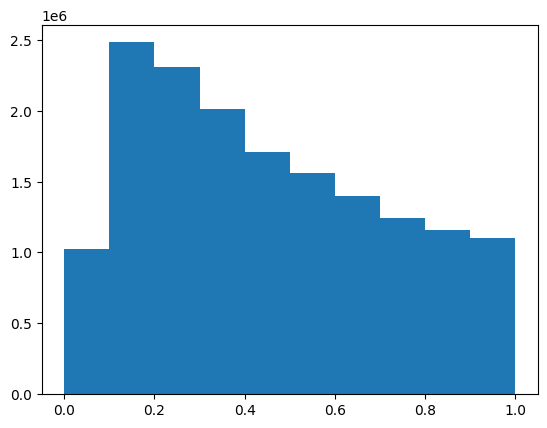

In [28]:
plt.hist(edge_index[:,2])

(array([1023508., 2481750., 2305504., 2010462., 1710220., 1558028.,
        1397840., 1241018., 1161620., 1100408.]),
 array([0.        , 0.22177271, 0.44354542, 0.66531812, 0.88709083,
        1.10886354, 1.33063625, 1.55240896, 1.77418166, 1.99595437,
        2.21772708]),
 <BarContainer object of 10 artists>)

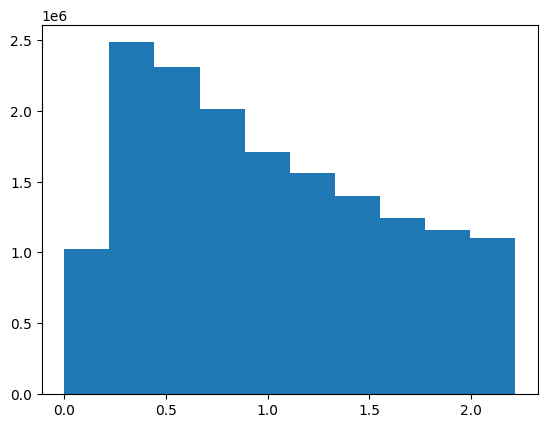

In [37]:
plt.hist(edge_index[:,2]/theta)

In [38]:
edge_index[:,2] = (np.exp(-edge_index[:,2]/theta) != 1)*(np.exp(-edge_index[:,2]/theta))

In [39]:
edge_index = edge_index.tolist()

In [49]:
edge = np.array(edge_index)

(array([ 104858., 2675184., 2488602., 2069742., 1852894., 1745952.,
        1629948., 1487948., 1312172.,  623058.]),
 array([0.        , 0.09151076, 0.18302152, 0.27453228, 0.36604304,
        0.45755381, 0.54906457, 0.64057533, 0.73208609, 0.82359685,
        0.91510761]),
 <BarContainer object of 10 artists>)

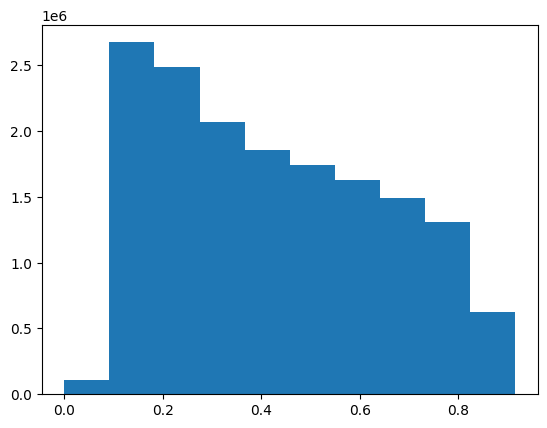

In [51]:
plt.hist(edge[:,2])

In [53]:
selected_edges = [(int(row[0]), int(row[1])) for row in edge_index if row[2] > 0.8]
edge_index_selected = torch.tensor(selected_edges, dtype=torch.long).t()

In [54]:
x = torch.tensor(df['amt'], dtype=torch.float).reshape(-1,1)
y = torch.tensor(df['is_fraud'],dtype=torch.int64)
data = torch_geometric.data.Data(x=x, edge_index = edge_index_selected, y=y, train_mask = train_mask, test_mask = test_mask)
data

Data(x=[104858, 1], edge_index=[2, 932496], y=[104858], train_mask=[104858], test_mask=[104858])

In [55]:
torch.manual_seed(202250926)

class GCN1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 32)
        self.conv2 = GCNConv(32,2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

X = (data.x[data.train_mask]).numpy()
XX = (data.x[data.test_mask]).numpy()
y = (data.y[data.train_mask]).numpy()
yy = (data.y[data.test_mask]).numpy()

model = GCN1()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()
for epoch in range(400):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
model.eval()

pred = model(data).argmax(dim=1) # argmax말고
yyhat = pred[data.test_mask]

pred

metrics = [sklearn.metrics.accuracy_score,
           sklearn.metrics.precision_score,
           sklearn.metrics.recall_score,
           sklearn.metrics.f1_score,
           sklearn.metrics.roc_auc_score]

_results2= pd.DataFrame({m.__name__:[m(yy,yyhat).round(6)] for m in metrics},index=['분석1'])
_results2

,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
분석1,0.994202,0.0,0.0,0.0,0.5
